In [ ]:
# Import necessary libraries

import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import haversine_distances
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, mean_squared_error
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import matplotlib.pyplot as plt

In [2]:
# 0. Load the dataset

data_path = 'partial_data.csv'
taxi_data = pd.read_csv(data_path)

# 1. Data Preprocessing

# Convert datetime columns to datetime objects
taxi_data[' pickup_datetime'] = pd.to_datetime(taxi_data[' pickup_datetime'])
taxi_data[' dropoff_datetime'] = pd.to_datetime(taxi_data[' dropoff_datetime'])

# Remove invalid or zero values
taxi_data = taxi_data[
    (taxi_data[' trip_distance'] > 0) &
    (taxi_data[' trip_time_in_secs'] > 0) &
    (taxi_data[' pickup_longitude'] < -71) &
    (taxi_data[' pickup_longitude'] > -78) &
    (taxi_data[' pickup_latitude'] > 0) &
    (taxi_data[' dropoff_longitude'] < -71) &
    (taxi_data[' dropoff_longitude'] > -78) &
    (taxi_data[' dropoff_latitude'] > 0)
]

In [3]:
# 2. Feature Engineering

# Add derived features for time and speed
taxi_data[' pickup_hour'] = taxi_data[' pickup_datetime'].dt.hour
taxi_data[' speed_mph'] = taxi_data[' trip_distance'] / (taxi_data[' trip_time_in_secs'] / 3600)

# Convert pickup latitude and longitude into radians for clustering
pickup_coords = np.radians(taxi_data[[' pickup_longitude', ' pickup_latitude']])

# Apply K-Means clustering to define pickup zones
kmeans = KMeans(n_clusters=8, random_state=42)
taxi_data[' pickup_zone'] = kmeans.fit_predict(pickup_coords)

# Extract weekday and peak hour
taxi_data[' pickup_weekday'] = taxi_data[' pickup_datetime'].dt.weekday
taxi_data[' is_peak_hour'] = taxi_data[' pickup_hour'].apply(lambda x: 1 if 7 <= x <= 9 or 16 <= x <= 19 else 0)

# Calculate haversine distance
pickup_coords = np.radians(taxi_data[[' pickup_latitude', ' pickup_longitude']])
dropoff_coords = np.radians(taxi_data[[' dropoff_latitude', ' dropoff_longitude']])
earth_radius_km = 6371
taxi_data[' haversine_distance_km'] = (
    haversine_distances(pickup_coords, dropoff_coords).diagonal() * earth_radius_km
)

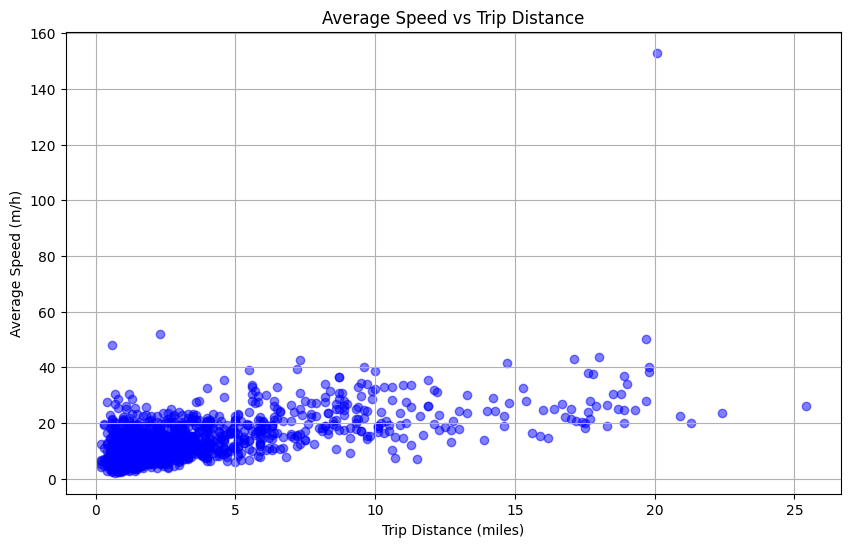

In [4]:
# 4.1 Visualize: Speed vs Distance (Average Speed vs Trip Distance)

plt.figure(figsize=(10, 6))
plt.scatter(taxi_data[' trip_distance'], taxi_data[' speed_mph'], alpha=0.5, color='blue')
plt.title('Average Speed vs Trip Distance')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Average Speed (m/h)')
plt.grid(True)
plt.show()

In [5]:
# 3.1 Data Modelling: Traffic Congestion Prediction (Classification)

# Create congestion label: "1" if speed < 10 mph, otherwise "0"
taxi_data[' congested'] = (taxi_data[' speed_mph'] < 10).astype(int)

# Features and target
features = [' pickup_hour', ' pickup_weekday', ' trip_distance', ' haversine_distance_km']
target = ' congested'

X = taxi_data[features]
y = taxi_data[target]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use StratifiedKFold to address class imbalance
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Define hyperparameter grid for RandomForestClassifier
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [10, 15, 20],        # Maximum depth of the tree
    'min_samples_split': [2, 5, 10]   # Minimum samples required to split an internal node
}

# Initialize RandomForestClassifier
clf = RandomForestClassifier(random_state=42)

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=skf,  # Use StratifiedKFold for cross-validation
    scoring='f1_weighted',  # Weighted F1 score for imbalanced data
    verbose=2,
    n_jobs=-1  # Use all available CPU cores
)
grid_search.fit(X_train, y_train)

# Get the best parameters and classifier
grid_best_clf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Predictions on the test set
y_pred_traffic_congestion = grid_best_clf.predict(X_test)

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred_traffic_congestion))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_traffic_congestion))

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=10, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END max_depth=10, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END max_depth=10, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_split=5, n_es

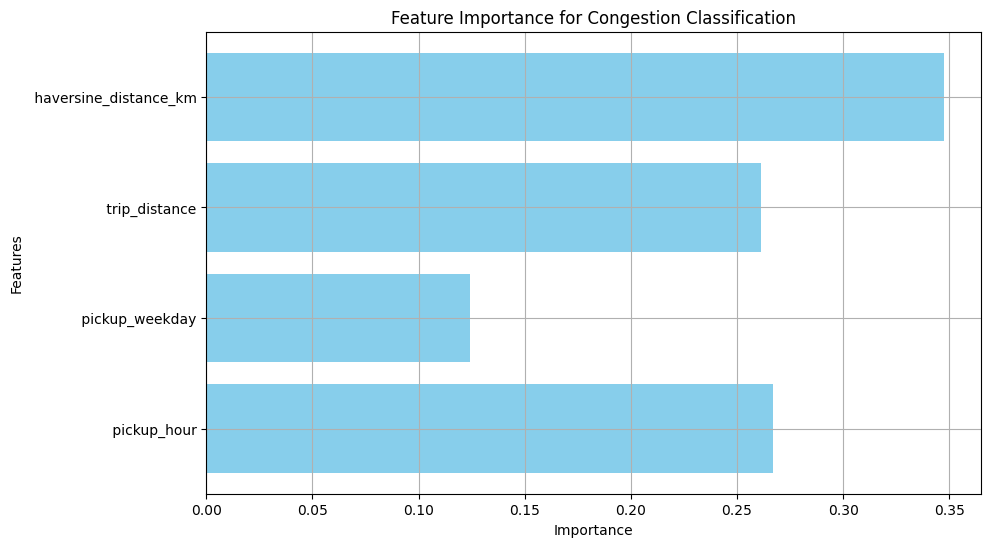

In [8]:
# 4.2 Visualize: Feature Importance for Classifier

classifier_traffic_congession_importances = grid_best_clf.feature_importances_
feature_names = X_train.columns

plt.figure(figsize=(10, 6))
plt.barh(feature_names, classifier_traffic_congession_importances, color='skyblue')
plt.title('Feature Importance for Congestion Classification')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.grid(True)
plt.show()

In [9]:
# 3.2 Data Modelling: Traffic Density Prediction (Regression)

# Predict traffic density using speed as the target
speed_target = ' speed_mph'

X = taxi_data[features]
y = taxi_data[speed_target]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define hyperparameter grid for Random Forest Regressor
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [10, 15, 20],        # Maximum depth of the tree
    'min_samples_split': [2, 5, 10]   # Minimum samples required to split an internal node
}

# Perform Grid Search for Hyperparameter Tuning
regressor = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=regressor,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Best parameters and regressor
grid_best_regressor = grid_search.best_estimator_
print("Best Parameters for Regressor:", grid_search.best_params_)

# Predict and evaluate
y_pred_traffic_density = grid_best_regressor.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_traffic_density)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_traffic_density))

print(f"Mean Absolute Error: {mae:.2f} km/h")
print(f"Root Mean Squared Error: {rmse:.2f} km/h")

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=10, min_samples_split=2, n_estimators=300; total time=   0.6s
[CV] END max_depth=10, min_samples_split=2, n_estimators=300; total time=   0.6s
[CV] END max_depth=10, min_samples_split=2, n_estimators=300; total time=   0.6s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_split=5, n_es

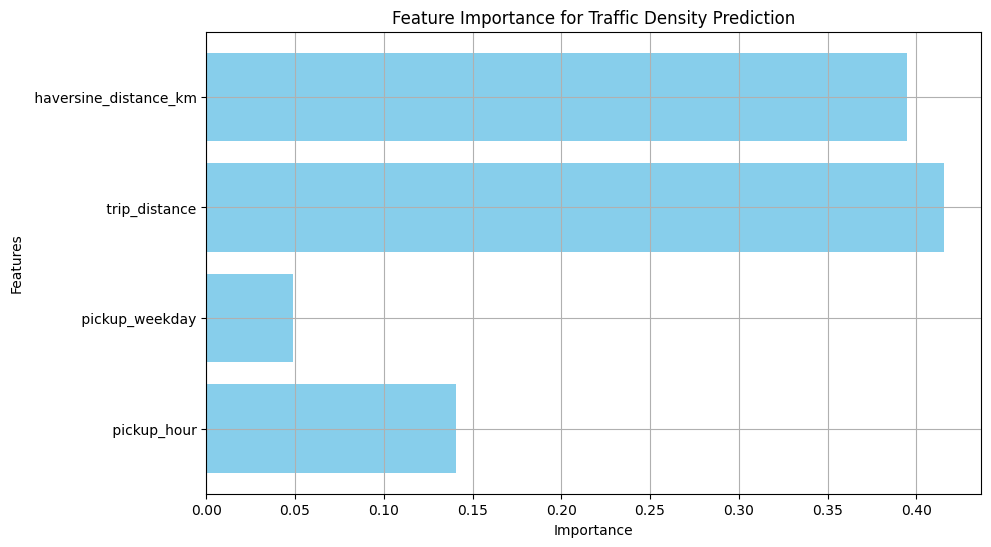

In [10]:
# # 4.2 Visualize: Feature importance

regressor_traffic_density_importances = grid_best_regressor.feature_importances_
feature_names = X_train.columns

plt.figure(figsize=(10, 6))
plt.barh(feature_names, regressor_traffic_density_importances, color='skyblue')
plt.title('Feature Importance for Traffic Density Prediction')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.grid(True)
plt.show()

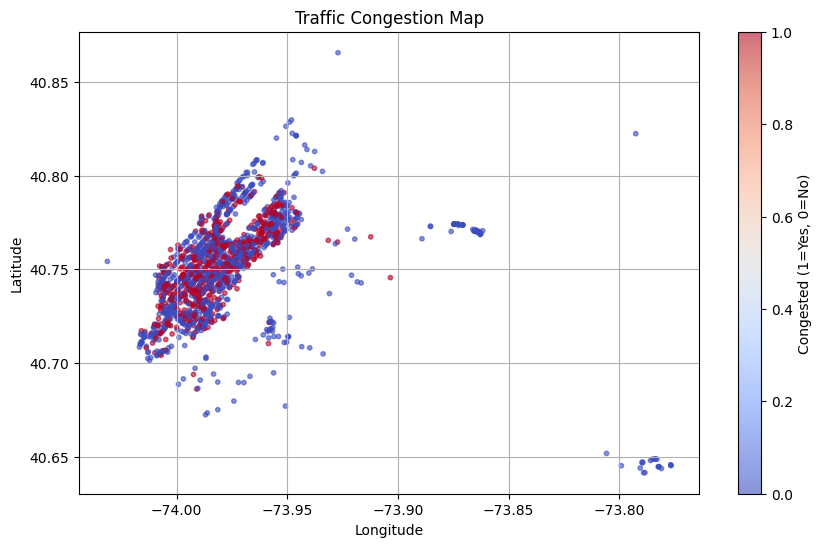

In [11]:
# Plot: Traffic Congestion Map
plt.figure(figsize=(10, 6))
plt.scatter(taxi_data[' pickup_longitude'], taxi_data[' pickup_latitude'], c=taxi_data[' congested'], cmap='coolwarm', s=10, alpha=0.6)
plt.colorbar(label='Congested (1=Yes, 0=No)')
plt.title('Traffic Congestion Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

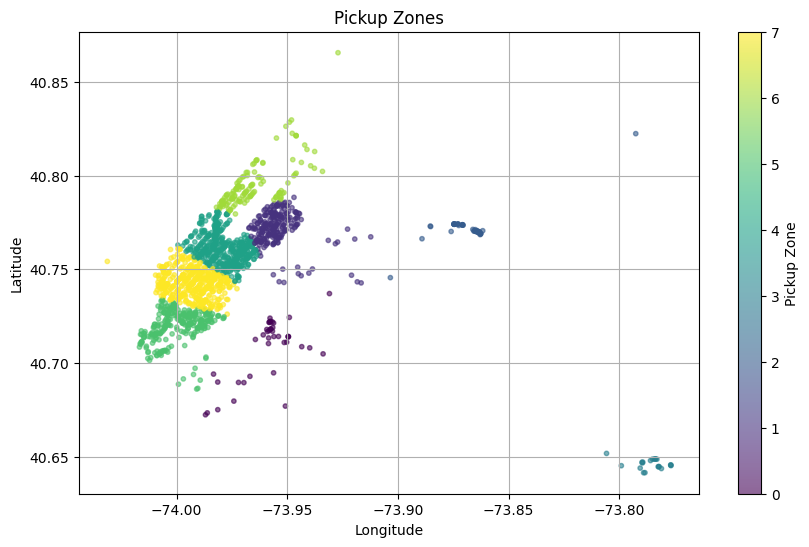

In [12]:
# Plot: Pickup Zones
plt.figure(figsize=(10, 6))
plt.scatter(
    taxi_data[' pickup_longitude'],
    taxi_data[' pickup_latitude'],
    c=taxi_data[' pickup_zone'],
    cmap='viridis',
    alpha=0.6,
    s=10
)
plt.colorbar(label='Pickup Zone')
plt.title('Pickup Zones')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

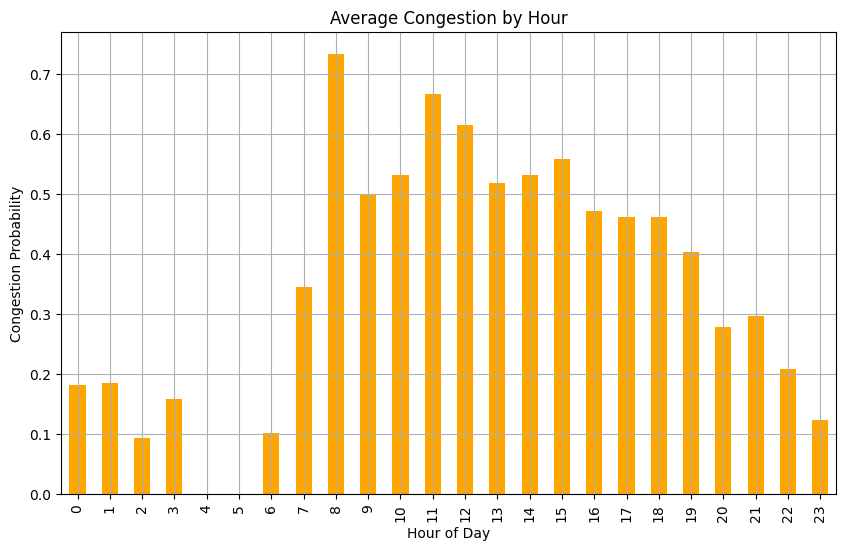

In [13]:
# Plot: Average Congestion by Hour
plt.figure(figsize=(10, 6))
taxi_data.groupby(' pickup_hour')[' congested'].mean().plot(kind='bar', color='orange')
plt.title('Average Congestion by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Congestion Probability')
plt.grid(True)
plt.show()

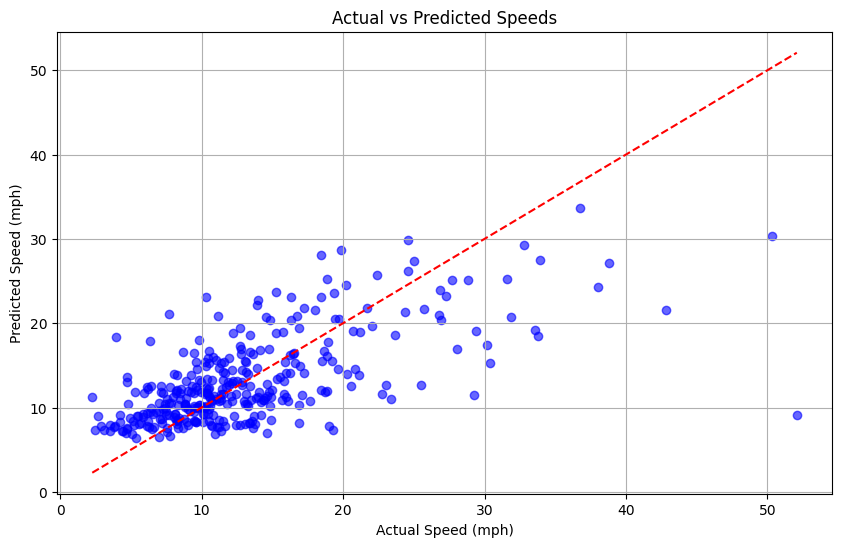

In [14]:
# Scatter Plot: Actual vs Predicted Speeds
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_traffic_density, alpha=0.6, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Actual vs Predicted Speeds')
plt.xlabel('Actual Speed (mph)')
plt.ylabel('Predicted Speed (mph)')
plt.grid(True)
plt.show()